In [1]:
import os
import random
import numpy as np
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight

import matplotlib.pyplot as plt
import datetime
import pickle

import kagglehub

AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE = 32
EPOCHS = 50
PATIENCE = 5

# Keep it simple: seed (optional, for repeatability of split)
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

2026-02-10 07:22:56.021157: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1770708176.205967      24 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1770708176.260861      24 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1770708176.715668      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770708176.715715      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770708176.715718      24 computation_placer.cc:177] computation placer alr

In [2]:
dataset_path = kagglehub.dataset_download('faysalmiah1721758/potato-dataset')
print("Data download complete:", dataset_path)

DATASET_DIR = dataset_path

class_names = sorted(os.listdir(DATASET_DIR))
print("Class names:", class_names)

Data download complete: /kaggle/input/datasets/faysalmiah1721758/potato-dataset
Class names: ['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']


In [3]:
file_paths = []
labels = []

for label_index, class_name in enumerate(class_names):
    class_dir = os.path.join(DATASET_DIR, class_name)
    for fname in os.listdir(class_dir):
        file_paths.append(os.path.join(class_dir, fname))
        labels.append(label_index)

file_paths = np.array(file_paths)
labels = np.array(labels)

print("Total images:", len(labels))

Total images: 2152


In [4]:
X_train, X_temp, y_train, y_temp = train_test_split(
    file_paths, labels, test_size=0.20, stratify=labels, random_state=SEED
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=SEED
)

print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")

Train: 1721, Val: 215, Test: 216


In [5]:
class_weight_vals = compute_class_weight(
    class_weight='balanced',
    classes=np.arange(len(class_names)),
    y=y_train
)
class_weight = dict(enumerate(class_weight_vals))
print("Class weights:", class_weight)

Class weights: {0: np.float64(0.7170833333333333), 1: np.float64(0.7170833333333333), 2: np.float64(4.741046831955923)}


In [6]:
from tensorflow.keras.applications.efficientnet import preprocess_input

IMAGE_SIZE_EFF = (224, 224)

def load_dataset_effnet(file_paths, labels, augment=False, shuffle=True, seed=42):
    ds = tf.data.Dataset.from_tensor_slices((file_paths, labels))

    def process(path, label):
        image = tf.io.read_file(path)
        image = tf.image.decode_jpeg(image, channels=3)
        image = tf.image.resize(image, IMAGE_SIZE_EFF)

        if augment:
            image = tf.image.random_flip_left_right(image)
            image = tf.image.random_brightness(image, max_delta=0.1)
            image = tf.image.random_contrast(image, lower=0.9, upper=1.1)

        # EfficientNet preprocessing (expects float32)
        image = tf.cast(image, tf.float32)
        image = preprocess_input(image)

        label = tf.one_hot(label, depth=len(class_names))
        return image, label

    ds = ds.map(process, num_parallel_calls=AUTOTUNE)

    if shuffle:
        ds = ds.shuffle(buffer_size=1000, seed=seed, reshuffle_each_iteration=True)

    ds = ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return ds

train_ds_eff = load_dataset_effnet(X_train, y_train, augment=True, shuffle=True, seed=SEED)
val_ds_eff   = load_dataset_effnet(X_val, y_val, augment=False, shuffle=False, seed=SEED)
test_ds_eff  = load_dataset_effnet(X_test, y_test, augment=False, shuffle=False, seed=SEED)

print("EfficientNet datasets ready.")

I0000 00:00:1770708192.607609      24 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15511 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


EfficientNet datasets ready.


In [7]:
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0

def build_efficientnet_b0(num_classes=3, input_shape=(224, 224, 3)):
    inputs = tf.keras.Input(shape=input_shape)

    backbone = EfficientNetB0(
        include_top=False,
        weights="imagenet",
        input_tensor=inputs
    )
    backbone.trainable = False  # frozen for fair transfer-learning baseline

    x = backbone.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.2)(x)  # light regularization
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = tf.keras.Model(inputs, outputs, name="EfficientNetB0_baseline")
    return model

effnet_model = build_efficientnet_b0(num_classes=len(class_names))
effnet_model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "EfficientNetB0_baseline"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,053,414 (15.46 MB)

 Trainable params: 3,843 (15.01 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [8]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

def train_and_evaluate_model_effnet(model, model_name, train_ds, val_ds, test_ds, class_names, class_weight, epochs=50):
    os.makedirs("models", exist_ok=True)
    os.makedirs("history", exist_ok=True)

    timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    run_name = f"{model_name}_{timestamp}"

    model_path = f"models/{run_name}.h5"
    history_path = f"history/{run_name}_history.pkl"
    plot_path = f"history/{run_name}_plot.png"
    cm_path = f"history/{run_name}_confusion_matrix.png"

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )

    early_stop = EarlyStopping(monitor="val_loss", patience=PATIENCE, restore_best_weights=True)
    checkpoint = ModelCheckpoint(model_path, monitor="val_loss", save_best_only=True)

    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        callbacks=[early_stop, checkpoint],
        class_weight=class_weight
    )

    with open(history_path, "wb") as f:
        pickle.dump(history.history, f)

    test_loss, test_acc = model.evaluate(test_ds, verbose=0)
    print(f"\n[{model_name}] Test Accuracy: {test_acc:.4f}")
    print(f"[{model_name}] Test Loss: {test_loss:.4f}")

    # Predictions
    y_true, y_pred = [], []
    for images, labels in test_ds:
        preds = model.predict(images, verbose=0)
        y_true.extend(np.argmax(labels.numpy(), axis=1))
        y_pred.extend(np.argmax(preds, axis=1))

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    fig, ax = plt.subplots(figsize=(8, 8))
    disp.plot(ax=ax, cmap="Blues", colorbar=False, xticks_rotation=45)
    plt.title(f"Confusion Matrix: {model_name}")
    plt.tight_layout()
    plt.savefig(cm_path)
    plt.show()

    # Curves
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history["accuracy"], label="Train Acc")
    plt.plot(history.history["val_accuracy"], label="Val Acc")
    plt.title("Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history["loss"], label="Train Loss")
    plt.plot(history.history["val_loss"], label="Val Loss")
    plt.title("Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.tight_layout()
    plt.savefig(plot_path)
    plt.show()

    print(f"\nSaved model: {model_path}")
    print(f"Saved history: {history_path}")
    print(f"Saved plot: {plot_path}")
    print(f"Saved confusion matrix: {cm_path}")

    return test_acc, test_loss

Epoch 1/50


I0000 00:00:1770708210.435443      64 service.cc:152] XLA service 0x78142c110f00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1770708210.435484      64 service.cc:160]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1770708212.922995      64 cuda_dnn.cc:529] Loaded cuDNN version 91002
I0000 00:00:1770708224.525523      64 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - accuracy: 0.5110 - loss: 1.0435

54/54 ━━━━━━━━━━━━━━━━━━━━ 56s 544ms/step - accuracy: 0.5120 - loss: 1.0423 - val_accuracy: 0.7349 - val_loss: 0.8708
Epoch 2/50
53/54 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.6966 - loss: 0.8551

54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.6978 - loss: 0.8533 - val_accuracy: 0.8651 - val_loss: 0.7322
Epoch 3/50
53/54 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.7875 - loss: 0.7189

54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.7879 - loss: 0.7179 - val_accuracy: 0.8930 - val_loss: 0.6280
Epoch 4/50
53/54 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.8509 - loss: 0.6467

54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.8507 - loss: 0.6451 - val_accuracy: 0.8791 - val_loss: 0.5536
Epoch 5/50
53/54 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.8511 - loss: 0.5631

54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.8519 - loss: 0.5621 - val_accuracy: 0.9023 - val_loss: 0.4912
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8774 - loss: 0.5032

54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.8774 - loss: 0.5027 - val_accuracy: 0.9070 - val_loss: 0.4435
Epoch 7/50
53/54 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8909 - loss: 0.4537

54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.8911 - loss: 0.4532 - val_accuracy: 0.9256 - val_loss: 0.4028
Epoch 8/50
53/54 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.8940 - loss: 0.4123

54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.8940 - loss: 0.4121 - val_accuracy: 0.9349 - val_loss: 0.3694
Epoch 9/50
53/54 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9163 - loss: 0.3657

54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.9163 - loss: 0.3657 - val_accuracy: 0.9349 - val_loss: 0.3453
Epoch 10/50
53/54 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9155 - loss: 0.3383

54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.9157 - loss: 0.3383 - val_accuracy: 0.9442 - val_loss: 0.3185
Epoch 11/50
53/54 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9205 - loss: 0.3266

54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.9208 - loss: 0.3264 - val_accuracy: 0.9488 - val_loss: 0.2966
Epoch 12/50
53/54 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9328 - loss: 0.2873

54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.9329 - loss: 0.2878 - val_accuracy: 0.9535 - val_loss: 0.2734
Epoch 13/50
53/54 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9309 - loss: 0.2919

54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.9310 - loss: 0.2917 - val_accuracy: 0.9535 - val_loss: 0.2590
Epoch 14/50
53/54 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9521 - loss: 0.2760

54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.9517 - loss: 0.2756 - val_accuracy: 0.9628 - val_loss: 0.2387
Epoch 15/50
53/54 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9448 - loss: 0.2671

54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.9450 - loss: 0.2667 - val_accuracy: 0.9628 - val_loss: 0.2272
Epoch 16/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9492 - loss: 0.2223

54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.9491 - loss: 0.2226 - val_accuracy: 0.9721 - val_loss: 0.2121
Epoch 17/50
53/54 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9486 - loss: 0.2363

54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.9487 - loss: 0.2360 - val_accuracy: 0.9721 - val_loss: 0.2016
Epoch 18/50
53/54 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9516 - loss: 0.2258

54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.9515 - loss: 0.2258 - val_accuracy: 0.9721 - val_loss: 0.1945
Epoch 19/50
53/54 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9508 - loss: 0.1989

54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.9509 - loss: 0.1992 - val_accuracy: 0.9767 - val_loss: 0.1836
Epoch 20/50
53/54 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9547 - loss: 0.2051

54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.9547 - loss: 0.2049 - val_accuracy: 0.9860 - val_loss: 0.1711
Epoch 21/50
53/54 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9469 - loss: 0.1901

54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.9472 - loss: 0.1903 - val_accuracy: 0.9767 - val_loss: 0.1686
Epoch 22/50
53/54 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9444 - loss: 0.2003

54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.9448 - loss: 0.1999 - val_accuracy: 0.9814 - val_loss: 0.1605
Epoch 23/50
53/54 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9589 - loss: 0.1804

54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - accuracy: 0.9587 - loss: 0.1805 - val_accuracy: 0.9860 - val_loss: 0.1544
Epoch 24/50
53/54 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9584 - loss: 0.1807

54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.9585 - loss: 0.1806 - val_accuracy: 0.9860 - val_loss: 0.1486
Epoch 25/50
53/54 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9611 - loss: 0.1747

54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.9611 - loss: 0.1745 - val_accuracy: 0.9907 - val_loss: 0.1408
Epoch 26/50
53/54 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9572 - loss: 0.1597

54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.9573 - loss: 0.1599 - val_accuracy: 0.9907 - val_loss: 0.1377
Epoch 27/50
53/54 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9557 - loss: 0.1602

54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.9560 - loss: 0.1603 - val_accuracy: 0.9814 - val_loss: 0.1358
Epoch 28/50
53/54 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9548 - loss: 0.1610

54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.9550 - loss: 0.1608 - val_accuracy: 0.9907 - val_loss: 0.1284
Epoch 29/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9591 - loss: 0.1688

54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.9592 - loss: 0.1685 - val_accuracy: 0.9907 - val_loss: 0.1240
Epoch 30/50
53/54 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9723 - loss: 0.1421

54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.9722 - loss: 0.1423 - val_accuracy: 0.9907 - val_loss: 0.1213
Epoch 31/50
53/54 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9674 - loss: 0.1433

54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.9674 - loss: 0.1433 - val_accuracy: 0.9953 - val_loss: 0.1145
Epoch 32/50
53/54 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9604 - loss: 0.1429

54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.9605 - loss: 0.1427 - val_accuracy: 0.9907 - val_loss: 0.1137
Epoch 33/50
53/54 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9596 - loss: 0.1384

54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.9598 - loss: 0.1384 - val_accuracy: 0.9953 - val_loss: 0.1088
Epoch 34/50
53/54 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9628 - loss: 0.1347

54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.9630 - loss: 0.1346 - val_accuracy: 0.9907 - val_loss: 0.1086
Epoch 35/50
53/54 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9645 - loss: 0.1291

54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.9646 - loss: 0.1292 - val_accuracy: 0.9907 - val_loss: 0.1040
Epoch 36/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9756 - loss: 0.1277

54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.9756 - loss: 0.1277 - val_accuracy: 0.9907 - val_loss: 0.1009
Epoch 37/50
53/54 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9656 - loss: 0.1360

54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.9657 - loss: 0.1357 - val_accuracy: 0.9907 - val_loss: 0.0990
Epoch 38/50
53/54 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9740 - loss: 0.1204

54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.9740 - loss: 0.1202 - val_accuracy: 0.9953 - val_loss: 0.0950
Epoch 39/50
53/54 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9612 - loss: 0.1308

54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.9615 - loss: 0.1303 - val_accuracy: 0.9953 - val_loss: 0.0911
Epoch 40/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9721 - loss: 0.1146

54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.9722 - loss: 0.1146 - val_accuracy: 0.9953 - val_loss: 0.0895
Epoch 41/50
53/54 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9685 - loss: 0.1094

54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.9686 - loss: 0.1095 - val_accuracy: 0.9907 - val_loss: 0.0895
Epoch 42/50
53/54 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9654 - loss: 0.1160

54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.9657 - loss: 0.1156 - val_accuracy: 0.9953 - val_loss: 0.0852
Epoch 43/50
53/54 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9698 - loss: 0.1125

54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.9698 - loss: 0.1124 - val_accuracy: 0.9953 - val_loss: 0.0837
Epoch 44/50
53/54 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9688 - loss: 0.1079

54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.9689 - loss: 0.1079 - val_accuracy: 0.9953 - val_loss: 0.0808
Epoch 45/50
53/54 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9622 - loss: 0.1170

54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.9622 - loss: 0.1167 - val_accuracy: 0.9953 - val_loss: 0.0785
Epoch 46/50
53/54 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9747 - loss: 0.1046

54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.9747 - loss: 0.1045 - val_accuracy: 0.9953 - val_loss: 0.0741
Epoch 47/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.9738 - loss: 0.1018 - val_accuracy: 0.9953 - val_loss: 0.0758
Epoch 48/50
53/54 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9716 - loss: 0.1035

54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.9717 - loss: 0.1035 - val_accuracy: 0.9953 - val_loss: 0.0736
Epoch 49/50
53/54 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9659 - loss: 0.1029

54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.9663 - loss: 0.1026 - val_accuracy: 0.9953 - val_loss: 0.0718
Epoch 50/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.9830 - loss: 0.0890 - val_accuracy: 0.9953 - val_loss: 0.0719

[EfficientNetB0] Test Accuracy: 0.9583
[EfficientNetB0] Test Loss: 0.1214

Classification Report:
                       precision    recall  f1-score   support

Potato___Early_blight       0.98      0.99      0.99       100
 Potato___Late_blight       0.98      0.93      0.95       100
     Potato___healthy       0.75      0.94      0.83        16

             accuracy                           0.96       216
            macro avg       0.90      0.95      0.92       216
         weighted avg       0.96      0.96      0.96       216



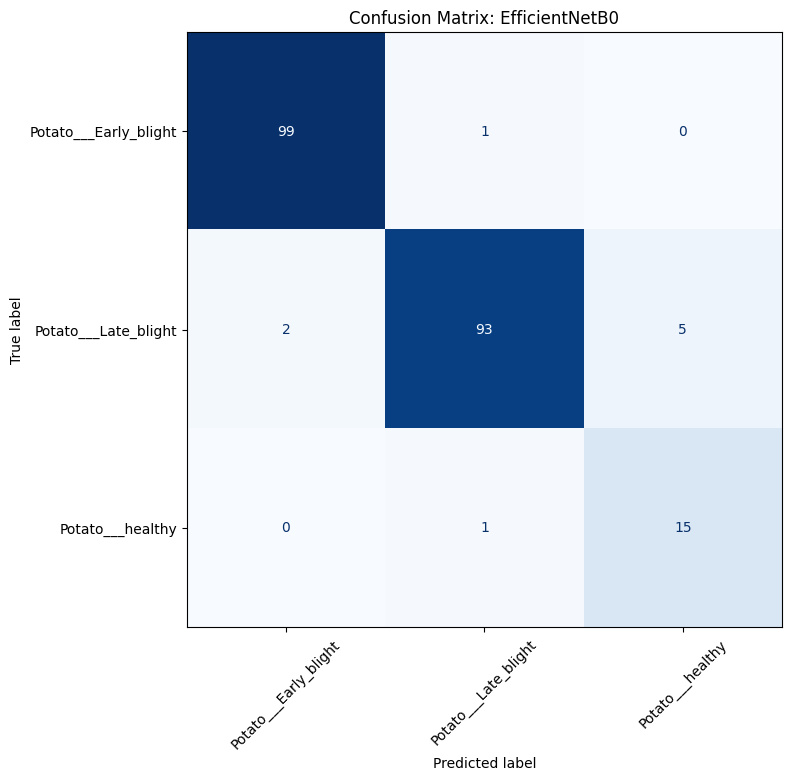

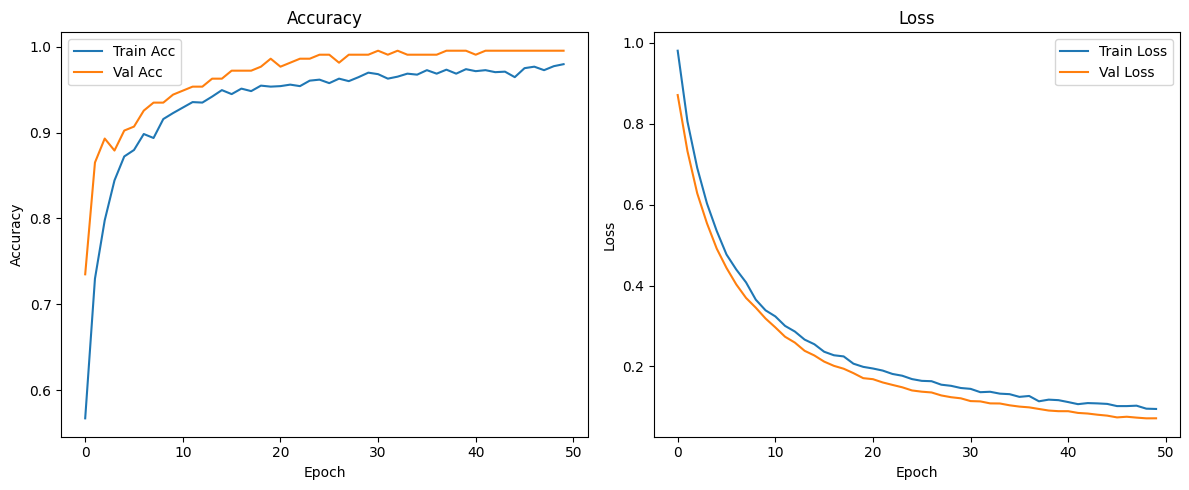


Saved model: models/EfficientNetB0_20260210-072318.h5
Saved history: history/EfficientNetB0_20260210-072318_history.pkl
Saved plot: history/EfficientNetB0_20260210-072318_plot.png
Saved confusion matrix: history/EfficientNetB0_20260210-072318_confusion_matrix.png

EfficientNetB0 Final: 0.9583333134651184 0.12136813998222351


In [9]:
effnet_model = build_efficientnet_b0(num_classes=len(class_names))
effnet_acc, effnet_loss = train_and_evaluate_model_effnet(
    model=effnet_model,
    model_name="EfficientNetB0",
    train_ds=train_ds_eff,
    val_ds=val_ds_eff,
    test_ds=test_ds_eff,
    class_names=class_names,
    class_weight=class_weight,
    epochs=EPOCHS
)

print("\nEfficientNetB0 Final:", effnet_acc, effnet_loss)

In [10]:
def count_params_millions(model):
    return model.count_params() / 1e6

print("EfficientNetB0 params (M):", round(count_params_millions(effnet_model), 2))

EfficientNetB0 params (M): 4.05
